In [322]:
# library imports
from importlib import reload
from copy import deepcopy
from Classes import ClusterObj, BlockObj, ScanDataObj
from Functions import CommonFunctions, ClassesFunctions
import pickle
import pandas as pd
reload(CommonFunctions)
reload(ClassesFunctions)
reload(ClusterObj)
reload(BlockObj)
reload(ScanDataObj)

print('Done!')

Done!


In [323]:
# path setup
path = "/Users/afarinaqs/Library/CloudStorage/Box-Box/Home Folder aa714/Private/BME LAB/Afi/OOD Detection/Data/P24-1204/"
input_file_name = 'Day15_S2_N6_SD4_5um'

image, scaled_image = CommonFunctions.load_image(file_name=input_file_name, path=path, debug=False, plot_images=False, rotation=0)
print(f'Loaded Image "{input_file_name}" {image.shape}')


Loaded Image "Day15_S2_N6_SD4_5um" (14400, 4400)


In [324]:
# load the saved work, or start over:
scan_data = ClassesFunctions.read_scan_data_from_pickle(
    file_name=input_file_name,
    path=path,
    start_over=False, # if True -> ignores the pickle, and returns None for initiating with the following functions
    plot_results=False,
    debug=False
)

reset = False
if scan_data is None or reset:
    print('Need to start over and make the dataset')
    start_over = True
else:
    print(f'Successfully loaded scan_data for "{input_file_name}"')
    start_over = False



Successfully loaded scan_data for "Day15_S2_N6_SD4_5um"


In [325]:
## Setting the parameters:
# start_over = True
scan_size = 5       # scanned at 5 or 10 µm
assay = 'SD4'       # put either "SD4" (screening D4) or "OF" (open format)
cAb_names = ['anti_cy5', 'cAb10', 'cAb28', 'cAb9'] # name of cAbs from top to bottom.(can be None or [] too)

In [326]:
# reset = True/False to overwrite start_over
ScanDataObj.init_or_reset_params(file_name=input_file_name, reset=start_over, input_param_dict=None, debug=False)


Skipping param initiation because they are already loaded from pickle files for Day15_S2_N6_SD4_5um


In [327]:
# todo: add a function for parameter tuning...

In [328]:
# test current parameters. can optimize them too if the results are not looking good.
if start_over:
    test_image = deepcopy(image)[100:1000,1400:3000] #(y,x) -> change if u want!

    # checkme takes too long
    # CommonFunctions.optimize_the_params(file_name=input_file_name, input_image=test_image, how_many_times=1, plot_images=False, debug=False)

    CommonFunctions.test_current_parameters(input_image=test_image, file_name=input_file_name, fig_size=[9,9], debug=False)

In [329]:
# start_over=True
if start_over or not scan_data.sorted_circles:
    CommonFunctions.do_initial_circle_finding(file_name=input_file_name, debug=False, plot_images=False)
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
else:
    sorted_circles, predicted_clusters_ids = [],[]

In [330]:
# start_over = False
if start_over:
    ClassesFunctions.init_blocks_dict(
        file_name=input_file_name, debug=False, plot_blocks=start_over,
        # debug_block_ids=['r0c0','r0c1','r0c2','r0c3'],
        # init_offset=[-20,00],
        # block_size_adjustment=[100,100],
        # block_distance_adjustment=[-100,-110],
    )
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [331]:
# start_over = True
if start_over:
    ClassesFunctions.init_clusters_dict(scan_data.sorted_circles, scan_data.predicted_clusters_ids, input_file_name,
                                        optimize_spots_coords=True, debug=False, debug_clusters_ids=[])
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [332]:
# connect clusters and blocks (and final initiation stuff)
if start_over:
    ClassesFunctions.connect_clusters_to_blocks(file_name=input_file_name,debug=False,debug_clusters=[],debug_blocks=[],plot_images=False,)
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [333]:
# print(test_block.full_report(1))

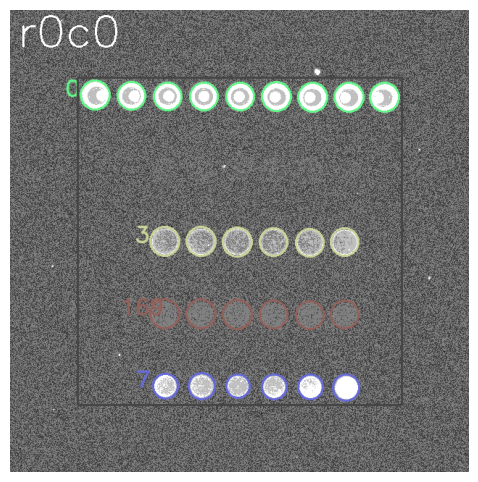

There are 4 clusters in total.


In [336]:
## Making the first template of cluster patterns
start_over=True

test_ind = f'r0c0'
test_block: BlockObj.Block = scan_data.get_block(test_ind)
if start_over:
    scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
    manual_spot_edit_dict = {
        3:['add 1 cluster below d=100']
    }
    test_block.edit_block(debug=0, plot_before_after=False, overwrite=True,with_restore=True,
                          manual_spot_edit_dict=manual_spot_edit_dict)
    test_mask = test_block.create_block_mask(debug=False, plot_images=False)
    test_block.plot_block(fig_size=[6, 6], debug=False, with_border=True, crop_to_mask=True)
    N = len(test_block.clusters_ids_list)
    print(f'There are {N} clusters in total.')
    # print(test_block.full_report(1))


In [171]:
# generating the list to edit each row at the same time
generate_list = lambda n: [f'r{n}c{i}' for i in range(scan_data.block_ncol)]
rows_names_list = []
for r in range(scan_data.block_nrow):
    rows_names_list.append(generate_list(r))

In [172]:
# row 0
r = 0
plot_results = False if start_over else True
current_list = rows_names_list[r]
fig_size = [10,10] if scan_data.assay == 'SD4' else [15,15]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={'r0c1':[0,0],'r0c2':[0,-200],'r0c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c2'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            # 15:['del']
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)

# print(scan_data.get_block('r0c1').full_report(1))

['r0c0', 'r0c1', 'r0c2', 'r0c3']
0


TypeError: can only concatenate str (not "NoneType") to str

In [ ]:
## row 1
r = 1
current_list = rows_names_list[r]

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        # move_whole_block_match={'r1c0':[0,0],'r1c1':[0,0],'r1c2':[0,-100]},
        manual_spot_edit_dict={
            # 20:['change_r spot0 r-2','change_r spot1 r-3','change_r spot-1 r-2','move spot-1 1 r, 1 d','move spot02 1 d'],
            # 175:['change_r all r-1','move all 2 d'],
            # 21:['change_r spot-1 r-2']
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)

In [ ]:
# row 2
r = 2
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        # move_whole_block_match={'r2c0':[0,0],'r2c1':[10,0],'r2c2':[90,30],'r2c3':[-30,-194]},
        manual_spot_edit_dict={
            # 179:['move all 2 u, 2 l']
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)

In [ ]:
# row 3
r = 3
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        # move_whole_block_match={'r3c0':[20,0],'r3c1':[20,200],'r3c2':[0,-100]},
        manual_spot_edit_dict={
            # 44:['change_r spot0 r-2','change_r spot-2 r-1'],
            # 46:['change_r spot1 r-2','change_r spot-2 r-2','move spot-2 1 d , 1 r']
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
# row 4
r = 4
start_over = 1
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        # move_whole_block_match={'r4c0':[0,0],'r4c1':[0,0],'r4c2':[0,0],'r4c3':[50,0]},
        manual_spot_edit_dict={
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
# row 5
r = 5
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        # move_whole_block_match={'r5c0':[0,0],'r5c1':[0,0], 'r5c2':[0,-100]},
        manual_spot_edit_dict={
            70:['change_r all r-1']
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
# row 6
r = 6
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        # move_whole_block_match={'r6c1':[20,20],'r6c2':[100,0]},
        manual_spot_edit_dict={
            # 195:['move all 1 d']
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 7
r = 7
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        move_whole_block_match={'r7c0':[0,0], 'r7c1':[0,-200],'r7c2':[0,-200],'r7c3':[0,-200], },
        manual_spot_edit_dict={
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 8
if scan_data.block_nrow > 8:
    r = 8
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
            debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
            preprocess_params=scan_data.preprocess_params, plot_before_after=0,
            move_whole_block_match={'r8c0':[0,-200], 'r8c1':[0,-200],'r8c2':[0,-200],},
            manual_spot_edit_dict={
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 9
if scan_data.block_nrow > 8:
    r = 9
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N, fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            move_whole_block_match={'r9c0':[0,-200],'r9c2':[0,-200]},
            manual_spot_edit_dict={
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 10
if scan_data.block_nrow > 8:
    r = 10
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N, fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            move_whole_block_match={'r10c0':[0,-200]},
            manual_spot_edit_dict={
                # 139:['change_r all r+1','move spot0 3 l, 6 d']
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)



In [ ]:
##### row 11
if scan_data.block_nrow > 8:
    r = 11
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            move_whole_block_match={'r11c0':[0,-200],'r11c1':[0,-200]},
            manual_spot_edit_dict={
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 12
if scan_data.block_nrow > 8:
    r = 12
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            move_whole_block_match={'r12c0': [0,-200],'r12c2': [0,0],'r12c3': [-50,-400],},
            manual_spot_edit_dict={
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 13
if scan_data.block_nrow > 8:
    r = 13
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            move_whole_block_match={'r13c1': [0,0], 'r13c3': [0,-100],},
            manual_spot_edit_dict={
            }
        )
    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
    ##### row 14
if scan_data.block_nrow > 8:
        r = 14
        current_list = rows_names_list[r]
        print(current_list)

        if start_over:
            ClassesFunctions.edit_multiple_blocks(
                current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N, fig_size=fig_size,
                debug=0, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
                move_whole_block_match={'r14c3':[50,0]},
                manual_spot_edit_dict={
                }
            )

        elif plot_results:
            ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
# scan_data.get_block('r15c0').update_block_start_end_from_clusters_min_max()

In [ ]:
##### row 15
if scan_data.block_nrow > 8:
    r = 15
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            manual_spot_edit_dict={
            }
        )


    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)


In [ ]:
scan_data.cAb_names = ['anti_cy5', 'cAb10', 'cAb28', 'cAb9']
scan_data.cAb_names

In [ ]:
## Additional test info and labeling
scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
test_info = {'Ag': 'Omicron', 'dAb': 'dAb34'}

if scan_data.assay =='OF':
    curve_num_points = 8
    start_Ag_conc = 250
    dilution_factor = 2
    num_rep = 3
    num_blank_rows_at_bottom = 1
    test_info['start_blocks'] = ['r0c0','r0c1','r0c2']
    blank_rows = [scan_data.block_nrow - x - 1 for x in range(num_blank_rows_at_bottom)]
    weird_dilution = False
else:
    curve_num_points = 16
    start_Ag_conc = 250
    dilution_factor = 2
    num_rep = 4
    num_blank_rows_at_bottom = 2
    test_info['start_blocks'] = ['r0c0','r0c1','r0c2','r0c3']
    scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
    blank_rows = [scan_data.block_nrow - x - 1 for x in range(num_blank_rows_at_bottom)]
    weird_dilution = True

def add_labels(info_dict,debug=False, SD4_weird_dilution=False):
    for start_block_id in info_dict['start_blocks']:
        start_block = scan_data.get_block(start_block_id)
        start_block.dAb_label = info_dict['dAb']
        start_block.target = info_dict['Ag']
        start_block.Ag_conc = start_Ag_conc
        start_block.add_names_to_clusters(debug=debug)
        CommonFunctions.debug_report(f'{start_block_id}',debug)
        for n in range(1,curve_num_points):
            new_r = start_block.row_number + n
            new_block = scan_data.get_block(f'r{new_r}c{start_block.col_number}')
            new_block.dAb_label = info_dict['dAb']
            new_block.target = info_dict['Ag']
            if not SD4_weird_dilution:
                new_block.Ag_conc = start_Ag_conc/dilution_factor**(n) if new_r not in blank_rows else 0
            else:
                if new_block.row_number % 2 == 0:
                    new_block.Ag_conc = start_Ag_conc/dilution_factor**(int(n/2)) if new_r not in blank_rows else 0
                elif new_block.row_number % 2 == 1:
                    new_block.Ag_conc = (start_Ag_conc*0.75)/dilution_factor**(int((n-1)/2)) if new_r not in blank_rows else 0
            new_block.add_names_to_clusters(debug=debug)
            CommonFunctions.debug_report(f'r{new_r}c{start_block.col_number}',debug)
add_labels(info_dict=test_info, debug=0, SD4_weird_dilution=weird_dilution)
# ClassesFunctions.save_dicts_in_pickle(path=path)xx/

In [ ]:
scan_data.get_block('r2c0').Ag_conc

In [ ]:
# scan_data.get_block('r1c0').plot_block(description='cAb_names')

In [ ]:
out_dfs = []
sigma1 = 1.5
sigma2 = 2

# this one goes row by row:
for r in range(scan_data.block_nrow):
    block_ids_list = rows_names_list[r]
    out_df, counts = ClassesFunctions.measure_signal_of_blocks(
        block_ids_list=block_ids_list,
        file_name=input_file_name,
        sigma1=sigma1,
        sigma2=sigma2,
        fg_inc_pixels=1,
        margin_pixels=3,
        bg_r=6,
        debug=0,
        debug_blocks_ids=[''],
        plot_images=0,
    )
    out_dfs.append(out_df)
#     total_counts += counts1



In [ ]:
# wanna see everything for Z in rXcY:
cAb = 'anti_cy5'
row_id = 7
block_id = f'r{row_id}c0'
df1 = out_dfs[row_id]
df = df1[(df1['cAb_name']==cAb) & (df1['Block_ID']==block_id)]
scan_data.get_block(block_id).plot_block(description='cAb:intensities', crop_to_mask=1)
# print(df)
df

In [ ]:
# formated_path

In [ ]:
dosave=True
formated_path = path + input_file_name + '_scan_values'

if dosave:
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    intensities_df = pd.concat(out_dfs, ignore_index=True)
    with open(formated_path+'.pickle', 'wb') as file:
        pickle.dump(intensities_df, file)

    intensities_writer = pd.ExcelWriter(formated_path + '.xlsx')
    intensities_df.to_excel(intensities_writer, index=True)
    intensities_writer.close()


    print(f'saved intensities_df {intensities_df.shape}.')

else:
    with open(formated_path+'.pickle', 'rb') as file:
        intensities_df = pickle.load(file)
        print(f'loaded intensities_df {intensities_df.shape}')


intensities_df

In [ ]:
# to see what has been deleted.....
subset = intensities_df[intensities_df['F_B_PostProcess'].isnull()]

block_cab_pairs = set(zip(subset['Block_ID'], subset['cAb_name']))

filtered_df = intensities_df[
    intensities_df[['Block_ID', 'cAb_name']].apply(tuple, axis=1).isin(block_cab_pairs)
]

print(filtered_df.shape)
filtered_df.head(18)


In [ ]:
grouped = intensities_df.groupby(['Ag_Conc.', 'Row', 'Col', 'target', 'cAb_name', 'dAb_name'])['Average_F_B_PostProcess'].mean().reset_index()
grouped = grouped.sort_values(by=['Row', 'Col'])

if num_rep == 4 and curve_num_points==4:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}_" +
                                           ("0" if x['Row'] % 2 == 0 and x['Col'] % 2 == 0 else
                                            "1" if x['Row'] % 2 == 1 and x['Col'] % 2 == 0 else
                                            "2" if x['Row'] % 2 == 0 and x['Col'] % 2 == 1 else
                                            "3"), axis=1)
elif num_rep == 3:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}_" +
                                           ("0" if x['Col'] % 3 == 0 else
                                            "1" if x['Col'] % 3 == 1 else
                                            "2"), axis=1)

elif num_rep == 2:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}_" +
                                           ("0" if x['Row'] % 2 == 0 else "1"), axis=1)

elif num_rep == 1:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}", axis=1)

elif num_rep == 4 and curve_num_points==16:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}_" +
                                           ("0" if x['Col'] % 4 == 0 else
                                            "1" if x['Col'] % 4 == 1 else
                                            "2" if x['Col'] % 4 == 2 else
                                            "3"), axis=1)

grouped[grouped['cAb_name']=='cAb10'].head(10)



In [ ]:
results_df = grouped.pivot_table(index=['target', 'Ag_Conc.'], columns=[ 'dAb_cAb_rep'],
                                 values='Average_F_B_PostProcess').sort_values(by='Ag_Conc.',ascending=False)
print(results_df.shape)
results_df


In [ ]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

formated_path = path + input_file_name + '_summary'
results_writer = pd.ExcelWriter(formated_path + '.xlsx')
results_df.to_excel(results_writer, index=True)
results_writer.close()

with open(formated_path+'.pickle', 'wb') as file:
    pickle.dump(results_df, file)
